# Floorplanning with spectral methods
We run an experiment with a toy example to illustrate how spectral methods can help to floorplan a design and evaluate the impact of wire pipelining.

The experiment is as follows: a ring with $n$ nodes is created: $0-1-2-\cdots -(n-1)-0$. An extra edge is added to _break_ the regularity of the ring.

Spectral methods are used for the placement. We take the 2nd and 3rd smallest eigenvalues and their corresponding eigenvectors of the Laplacian matrix representing the graph. These eigenvectors determine the $x$ and $y$ coordinates of the nodes. The spreading of the nodes is guaranteed by the fact that the norm of the eigenvectors is 1.

After the first placement, we remove the extra edge and do placement again. We can see how the edges of the ring are shortened.

Finally, we do wire pipelining for the extra edge and we observe how the ring has a better placement than at the beginning.

In [1]:
from scipy import sparse
from scipy.sparse import csgraph
from scipy.sparse import linalg
import numpy as np
import math
import matplotlib.pyplot as plt
import time

This function creates the Laplacian of a graph consisting of a ring $0-1-2-\cdots -(n-1)-0$ and an extra edge $(a,b)$.

In [2]:
def create_ring(n, a, b):
    """ Creates the Laplacian of a graph that represents an undirected ring 0-1-2-...-(n-1)-0"""
    # Create the edges 0-1-2-(n-1)-0
    r = [i for i in range(n)]
    c = [(i+1)%n for i in range(n)]
    r.append(a)
    c.append(b)
    d = [1.0]*len(r)
    G = sparse.coo_matrix((d, (r, c)))
    # We want the matrix to be symmetric (undirected graph).We add the transpose.
    # We also want to calculate the Laplacian
    L = csgraph.laplacian(G + G.transpose(), normed=True) 
    return sparse.lil_matrix(L)

This function creates a grid graph

In [3]:
def encode(c , n):
    return c[1] +n*c[0]

def decode(k, n):
    j = k%n
    i = math.floor(k/n)
    return (i,j)

def create_grid(n):
    r = []
    c = []
    for i in range(n):
        for j in range(n):
            if (i > 0):
                r.append(encode((i,j),n))
                c.append(encode((i-1,j),n))
            if (i < n-1):
                r.append(encode((i,j),n))
                c.append(encode((i+1,j),n))
            if (j > 0):
                r.append(encode((i,j),n))
                c.append(encode((i,j-1),n))
            if (j < n-1):
                r.append(encode((i,j),n))
                c.append(encode((i,j+1),n))
    d = [1.0]*len(r)
    G = sparse.coo_matrix((d, (r, c)))
    L = csgraph.laplacian(G + G.transpose(), normed=True) 
    return sparse.lil_matrix(L)
                

This function creates a complete bipartite graph K_(a,b)

In [4]:
def create_complete_bipartite(a, b):
    r = []
    c = []
    for i in range(a):
        for j in range(a,a+b):
            r.append(i)
            c.append(j)
    d = [1.0]*len(r)
    G = sparse.coo_matrix((d, (r, c)),shape=(a+b,a+b))
    L = csgraph.laplacian(G + G.transpose(), normed=True) 
    return sparse.lil_matrix(L)

This function computes the sum of the length of the edges in the ring (without the extra edge). The edges of the ring are $0-1-2-\cdots -(n-1)-0$. The remaining edges are ignored.

In [5]:
def sum_edges(x, y, n):
    """Given the (x,y) coordinates of a ring, it calculates the length of the edges 0-1-2-...-(n-1)"""
    sum = 0
    for i in range(n-1):
        sum += np.sqrt((x[i]-x[i+1])**2+(y[i]-y[i+1])**2)
    sum += np.sqrt((x[0]-x[n-1])**2+(y[0]-y[n-1])**2)
    return sum

This function finds the longest edge in the graph and returns $(i,j,l)$, where $(i,j)$ is the longest edge and $l$ is the length. 

In [6]:
def longest_edge(G, x, y):
    maxl = 0
    rows,cols = G.nonzero()
    for row,col in zip(rows,cols):
        if row >= col: pass
        l = (x[row]-x[col])**2+(y[row]-y[col])**2
        if l > maxl:
            maxl = l
            maxr, maxc = row, col
    return maxr, maxc, np.sqrt(maxl)

This function checks if 2 points a, b are on the same side of a segment e

In [7]:
def SameSide(a, b, e, x, y):
    dx = x[e[0]]-x[e[1]]
    dy = y[e[0]]-y[e[1]]
    dxA = x[a]-x[e[0]]
    dyA = y[a]-y[e[0]]
    dxB = x[b]-x[e[0]]
    dyB = y[b]-y[e[0]]
    return (dy*dxA-dx*dyA > 0) == (dy*dxB - dx*dyB > 0)

This function checks if 2 edges intersect

In [8]:
def intersect(e1, e2, x, y):
    return not (SameSide(e1[0],e1[1],e2,x,y) or SameSide(e2[0],e2[1],e1,x,y))


This function counts intersections in a graph

In [9]:
def countintersections(G, x, y):
    ans = 0
    n = x.size
    for i in range(n):
        for j in range(len(G.data[i])):
            if (G.rows[i][j] >= i):
                break
            e1 = (i,G.rows[i][j])
            for a in range(i):
                for b in range(len(G.data[a])):
                    if (G.rows[a][b] >= a):
                        break
                    if (a == G.rows[i][j] or G.rows[a][b] == G.rows[i][j]):
                        continue
                        #may get false positivies if the 2 edges share a node
                    e2 = (a,G.rows[a][b])
                    if (intersect(e1, e2,x,y)):
                        print(str(e1) + " " + str(e2))
                        ans = ans+1
                        #Found an intersection
    return ans
            

In [10]:
def find_eigenvectors(G):
    V = linalg.eigsh(G, 3, which='SM')
    _, x, y = V[1].transpose() # ignore the 1st eigenvector and use the 2nd and 3rd as x and y coordinates
    return (x,y)

This function places the coordinates of the points and edges into text files

In [11]:
def totext(G, x, y):
    n = len(x)
    file = open("graphinfo.txt","w")
    file.write(str(len(x)) + "\n")
    for i in range(n):
        file.write(str(x[i])+" "+str(y[i]) + "\n")
    for i in range(n):
        for j in range(len(G.data[i])):
            if (G.rows[i][j] >= i):
                break
            file.write(str(i)+" "+str(G.rows[i][j]) + "\n")
    file.close()

This function plots the placement of the graph $G$ using spectral methods. It also reports the total length of the edges in the ring and the average length of the edges in the ring.

In [12]:
def plot_graph(G):
    """Performs spectral placement and plots the graph."""
    # We need the 2nd and 3rd smallest eigenvalues and the corresponding eigenvectors
    x, y = find_eigenvectors(G)
    totext(G, x, y)
    #s = sum_edges(x,y,n)
    #print("Total length of the edges in the ring:", s)
    #print("Avg.  length of the edges in the ring:", s/n)
    #i, j, l = longest_edge(G, x, y)
    #print("Longest edge: ", i, "--", j, " with length ", l, sep='')
    print("the number of intersections is: " + str(countintersections(G,x,y)))
    # Plot the nodes
    plt.scatter(x, y, s=120, zorder=2)
    for i in range(len(x)):
      plt.text(x[i]-.07, y[i], i, fontsize=12)
    
    # Plot the edges
    rows,cols = G.nonzero()
    for row,col in zip(rows,cols):
        if row >= col: pass
        plt.plot([x[row],x[col]], [y[row],y[col]], 'C3', zorder=1, lw=3)
   
    plt.gca().set_aspect(aspect='equal')
    plt.show()

We create a ring with 8 nodes and an extra edge $0-4$. We print the Laplacian of the graph.

In [13]:
G = create_complete_bipartite(3,3)
print("The Laplacian of the graph is as follows:")
print(G.toarray())
G = create_ring(8, 0, 4)
print("The Laplacian of the graph is as follows:")
print(G.toarray())

The Laplacian of the graph is as follows:
[[ 1.          0.          0.         -0.33333333 -0.33333333 -0.33333333]
 [ 0.          1.          0.         -0.33333333 -0.33333333 -0.33333333]
 [ 0.          0.          1.         -0.33333333 -0.33333333 -0.33333333]
 [-0.33333333 -0.33333333 -0.33333333  1.          0.          0.        ]
 [-0.33333333 -0.33333333 -0.33333333  0.          1.          0.        ]
 [-0.33333333 -0.33333333 -0.33333333  0.          0.          1.        ]]
The Laplacian of the graph is as follows:
[[ 1.         -0.40824829  0.          0.         -0.33333333  0.
   0.         -0.40824829]
 [-0.40824829  1.         -0.5         0.          0.          0.
   0.          0.        ]
 [ 0.         -0.5         1.         -0.5         0.          0.
   0.          0.        ]
 [ 0.          0.         -0.5         1.         -0.40824829  0.
   0.          0.        ]
 [-0.33333333  0.          0.         -0.40824829  1.         -0.40824829
   0.          0.  

We now plot the graph after placement. Notice how the edge $(0,4)$ creates an extra force that prevents an optimum placement of the ring.

the number of intersections is: 0


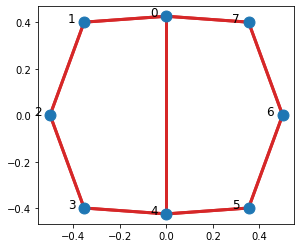

In [14]:
plot_graph(G)

We now modify the Laplacian to remove the edge $0-4$. The placement is much nicer and the average length of the edges in the ring is reduced.

the number of intersections is: 0


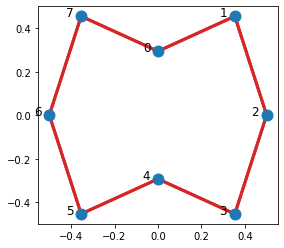

In [15]:
G[0,4] = G[4,0] = 0 # Remove the edge
G[0,0] = G[4,4] = 2 # Update the degree (in the diagonal)
plot_graph(G)

We now do wire pipelining. We create a ring with the extra edge $0-4$. But now we split the edge into two segments (wire pipelining): $0-8-4$. We can realize that the length of the ring is shorter than the one without wire pipelining. The longest edge in the graph is also shorter.

the number of intersections is: 0


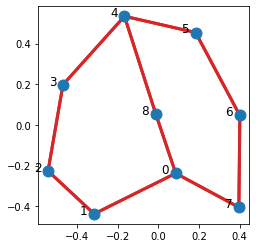

In [16]:
G = create_ring(9, 4, 8)
G[7,8] = G[8,7] = 0 # Remove the edge 7-8
G[0,7] = G[7,0] = -1 # Add the edge 0-7
G[0,0] = 3 # degree of 0
G[8,8] = 2 # degree of 8
plot_graph(G)

Case where we have 2 VAP of multiplicity 1 (4 possible graphs which are symmetries of each other)

the number of intersections is: 0


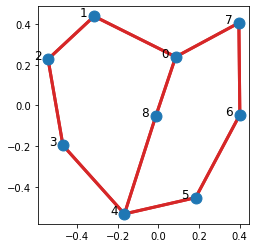

the number of intersections is: 0


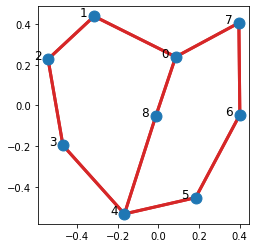

the number of intersections is: 0


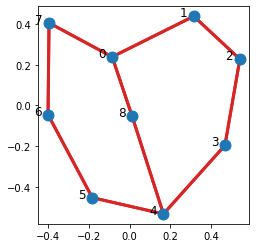

In [17]:
plot_graph(G)
plot_graph(G)
plot_graph(G)

Case where we have 1 VAP of multiplicity more than 1 (Infinite possible graphs)

(4, 0) (3, 1)
(4, 0) (3, 2)
(5, 2) (3, 1)
the number of intersections is: 3


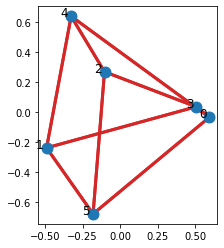

(5, 0) (4, 2)
the number of intersections is: 1


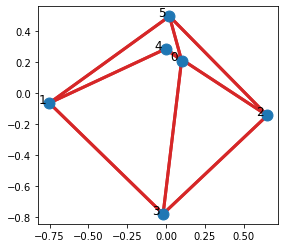

(4, 1) (3, 0)
(5, 0) (4, 1)
(5, 0) (4, 2)
(5, 1) (3, 0)
(5, 1) (4, 2)
the number of intersections is: 5


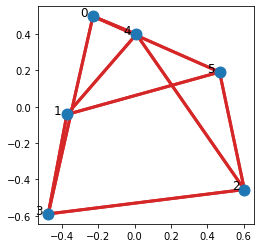

(5, 1) (4, 2)
the number of intersections is: 1


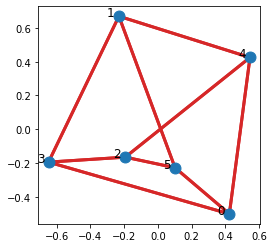

(5, 1) (3, 2)
the number of intersections is: 1


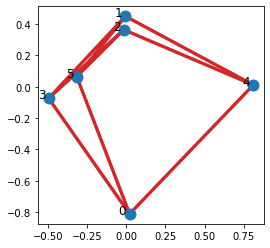

(4, 0) (3, 2)
(5, 0) (3, 2)
(5, 0) (4, 2)
the number of intersections is: 3


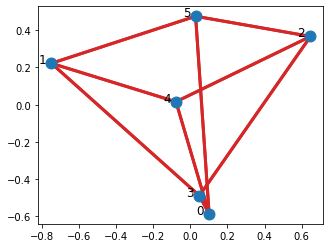

In [18]:
G = create_complete_bipartite(3,3)
plot_graph(G)
plot_graph(G)
plot_graph(G)
plot_graph(G)
plot_graph(G)
plot_graph(G)

There is a third case where we have 1 VAP of multiplicity 1 and 1 bigger VAP of multiplicity more than 1, though I haven't found an example of this yet

the number of intersections is: 0


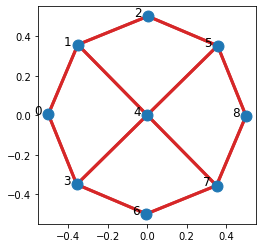

In [19]:
G = create_grid(3)
plot_graph(G)

In [20]:
G = create_complete_bipartite(5,6)
x, y = find_eigenvectors(G)
totext(G,x,y)
countintersections(G, x, y)

(7, 1) (5, 2)
(7, 1) (5, 3)
(7, 3) (5, 2)
(7, 4) (5, 1)
(7, 4) (5, 2)
(7, 4) (5, 3)
(8, 0) (6, 2)
(8, 0) (7, 3)
(8, 1) (5, 3)
(8, 2) (7, 3)
(8, 4) (5, 3)
(8, 4) (6, 1)
(9, 1) (5, 3)
(9, 1) (6, 2)
(9, 1) (7, 3)
(9, 1) (8, 0)
(9, 1) (8, 2)
(9, 2) (8, 0)
(9, 3) (6, 2)
(9, 4) (5, 1)
(9, 4) (5, 3)
(9, 4) (6, 2)
(9, 4) (7, 1)
(9, 4) (7, 3)
(9, 4) (8, 0)
(9, 4) (8, 2)
(10, 0) (5, 2)
(10, 0) (7, 2)
(10, 0) (7, 3)
(10, 0) (9, 4)
(10, 1) (5, 3)
(10, 2) (7, 3)
(10, 2) (9, 4)
(10, 3) (8, 0)
(10, 3) (8, 2)
(10, 3) (9, 1)
(10, 4) (5, 1)
(10, 4) (5, 3)
(10, 4) (7, 1)


39

(22, 12) (1, 0)
(22, 12) (2, 1)
(22, 21) (10, 0)
(22, 21) (20, 10)
(23, 13) (3, 2)
(23, 22) (1, 0)
(24, 14) (4, 3)
(25, 15) (6, 5)
(26, 16) (7, 6)
(27, 17) (8, 7)
(27, 17) (9, 8)
(27, 26) (9, 8)
(28, 27) (19, 9)
(29, 19) (28, 27)
(32, 22) (10, 0)
(32, 31) (30, 20)
(37, 27) (19, 9)
(39, 29) (38, 37)
(42, 41) (40, 30)
(49, 39) (48, 47)
(60, 50) (52, 51)
(69, 59) (58, 57)
(70, 60) (62, 61)
(79, 69) (68, 67)
(80, 70) (72, 71)
(89, 79) (78, 77)
(90, 80) (72, 62)
(90, 80) (72, 71)
(91, 90) (73, 72)
(91, 90) (82, 72)
(92, 91) (82, 72)
(93, 92) (83, 73)
(94, 93) (84, 74)
(96, 95) (85, 75)
(97, 96) (86, 76)
(98, 97) (87, 77)
(99, 89) (77, 67)
(99, 89) (78, 77)
(99, 98) (77, 76)
(99, 98) (87, 77)
the number of intersections is: 40


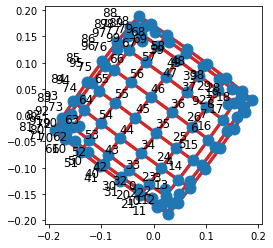

In [29]:
G = create_grid(10)
plot_graph(G)